<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-предобработка" data-toc-modified-id="Загрузка-и-предобработка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка</a></span></li><li><span><a href="#Подготовка-датасетов" data-toc-modified-id="Подготовка-датасетов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка датасетов</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></div>

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import numpy as np

import anthropic
import mistralai
from openai import OpenAI
from tqdm import tqdm
import pandas as pd
import json
import httpx
from pydantic import BaseModel
from dotenv import load_dotenv, dotenv_values
import os
import warnings
import time
import datetime
import joblib
import re
import random

import base64
import httpx


# Загрузка и предобработка

In [2]:
df = pd.read_csv('big_startup_secsees_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   permalink          66368 non-null  object
 1   name               66367 non-null  object
 2   homepage_url       61310 non-null  object
 3   category_list      63220 non-null  object
 4   funding_total_usd  66368 non-null  object
 5   status             66368 non-null  object
 6   country_code       59410 non-null  object
 7   state_code         57821 non-null  object
 8   region             58338 non-null  object
 9   city               58340 non-null  object
 10  funding_rounds     66368 non-null  int64 
 11  founded_at         51147 non-null  object
 12  first_funding_at   66344 non-null  object
 13  last_funding_at    66368 non-null  object
dtypes: int64(1), object(13)
memory usage: 7.1+ MB


In [3]:
df

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66363,/organization/zznode-science-and-technology-co...,ZZNode Science and Technology,http://www.zznode.com,Enterprise Software,1587301,operating,CHN,22,Beijing,Beijing,1,NaN,2012-04-01,2012-04-01
66364,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Advertising|Mobile|Web Development|Wireless,114304,operating,HRV,15,Split,Split,4,2012-05-13,2011-11-01,2014-03-01
66365,/organization/Áeron,ÁERON,http://www.aeron.hu/,NaN,-,operating,NaN,NaN,NaN,NaN,1,2011-01-01,2014-08-01,2014-08-01
66366,/organization/Ôasys-2,Ôasys,http://www.oasys.io/,Consumer Electronics|Internet of Things|Teleco...,18192,operating,USA,CA,SF Bay Area,San Francisco,1,2014-01-01,2015-01-01,2015-01-01


In [4]:
df[['founded_at', 'first_funding_at','last_funding_at']] = df[['founded_at', 'first_funding_at','last_funding_at']].apply(pd.to_datetime, errors='coerce')
df['funding_total_usd'] = pd.to_numeric(df.funding_total_usd, errors='coerce')
df.loc[df['status']=='ipo', 'status'] = 'operating'
df.loc[df['status']=='acquired', 'status'] = 'operating'

In [5]:
df[df['status']=='closed']

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
34,/organization/10bestthings,10BestThings,http://10bestthings.com,Curated Web,50000.0,closed,USA,OH,Cleveland,Cleveland,1,2009-04-01,2009-04-01,2009-04-01
47,/organization/11i-solutions,11i Solutions,http://www.11isolutions.com,Enterprise Software,1800000.0,closed,USA,AL,Huntsville,Huntsville,1,NaT,2011-03-22,2011-03-22
76,/organization/169-st,169 ST.,http://www.junebugreview.com,Entertainment|Games,50000.0,closed,USA,FL,Orlando,Lake Mary,1,2009-05-15,2009-06-01,2009-06-01
85,/organization/180solutions,180Solutions,NaN,Advertising|Advertising Platforms|Promotional,40000000.0,closed,USA,WA,Seattle,Bellevue,1,NaT,2004-04-05,2004-04-05
88,/organization/1bib,1bib,http://www.1bib.com,Cars|Curated Web,NaN,closed,CHN,30,Guangzhou,Guangzhou,1,2006-01-01,2008-02-07,2008-02-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66318,/organization/zuvvu,Zuvvu,http://zuvvu.com,Advertising|Social Media Advertising|Social Me...,12000.0,closed,IND,9,Ahmedabad,Ahmadabad,1,2010-06-01,2011-11-01,2011-11-01
66335,/organization/zygo,Zygo Communications,http://www.zygocommunications.com/who,Mobile|SMS,NaN,closed,GBR,H9,London,London,1,2005-06-21,2007-11-19,2007-11-19
66338,/organization/zykis,Zykis,http://zykis.com,Automotive|Data Security|Education|Kids|Portal...,800000.0,closed,USA,CA,Anaheim,Irvine,1,2006-10-27,2006-10-27,2006-10-27
66343,/organization/zymetis,Zymetis,http://www.zymetis.com,Biotechnology,2257464.0,closed,USA,MD,"Washington, D.C.",College Park,3,2006-01-01,2007-01-01,2010-01-31


In [6]:
df['status'].unique()

array(['operating', 'closed'], dtype=object)

In [7]:
df.isna().sum()

permalink                0
name                     1
homepage_url          5058
category_list         3148
funding_total_usd    12785
status                   0
country_code          6958
state_code            8547
region                8030
city                  8028
funding_rounds           0
founded_at           15225
first_funding_at        27
last_funding_at          0
dtype: int64

In [8]:
def set_founded_at(x):
    founded_at_date = x - datetime.timedelta(random.randint(180,720))
    return founded_at_date

def set_closed_at(row):
    if row['status'] == 'closed':
        return row['last_funding_at'] + datetime.timedelta(random.randint(360,720))
    else:
        return np.nan

In [9]:
df.loc[df['founded_at'].isna(), 'founded_at'] = df.loc[df['founded_at'].isna(), 'first_funding_at'].apply(set_founded_at)

In [10]:
df['closed_at'] = df.apply(set_closed_at, axis=1)

# db date 2018-01-01

In [11]:
df.isna().sum()

permalink                0
name                     1
homepage_url          5058
category_list         3148
funding_total_usd    12785
status                   0
country_code          6958
state_code            8547
region                8030
city                  8028
funding_rounds           0
founded_at               4
first_funding_at        27
last_funding_at          0
closed_at            60130
dtype: int64

In [12]:
df = df.dropna(subset='founded_at')

In [13]:
df.isna().sum()

permalink                0
name                     1
homepage_url          5058
category_list         3148
funding_total_usd    12784
status                   0
country_code          6958
state_code            8547
region                8030
city                  8028
funding_rounds           0
founded_at               0
first_funding_at        23
last_funding_at          0
closed_at            60126
dtype: int64

In [14]:
df = df.drop(columns=['permalink', 'homepage_url'])

In [15]:
df.columns.tolist()

['name',
 'category_list',
 'funding_total_usd',
 'status',
 'country_code',
 'state_code',
 'region',
 'city',
 'funding_rounds',
 'founded_at',
 'first_funding_at',
 'last_funding_at',
 'closed_at']

In [16]:
df[df.duplicated(subset=['name'])].shape

(265, 13)

In [17]:
df = df[~df.duplicated(subset=['name'])]

# Подготовка датасетов

In [18]:
train_df, test_df = train_test_split(df, stratify=df['status'], random_state=42, test_size=0.2)
submit_df = test_df.copy()

In [19]:
train_df.shape, test_df.shape

((52879, 13), (13220, 13))

In [20]:
train_df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
33534,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaT
16912,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
48225,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
49489,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
64123,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaT


In [21]:
train_df.duplicated(subset=['name']).sum()

0

In [22]:
test_df.duplicated().sum()

0

In [23]:
train_df.to_csv('kaggle_startups_train_01.csv', index=False)

In [24]:
def fill_status_random(x):
    statuses = ['operating', 'closed']
    random_status = random.randint(0,1)
    status = statuses[random_status]
    return status

def detect_outliers_date(dataset):
    df = dataset.copy()
    for column in ['founded_at', 'first_funding_at','last_funding_at']:
        up ='2018-01-01'
        down = '1970-01-01'
        df = df[(df[column]>down) | (df[column]<up)]
    df = df[~(df['closed_at']>up)]
    return df

# Подготовка данных

In [25]:
test_df = detect_outliers_date(test_df)
train_df = detect_outliers_date(train_df)

In [26]:
train_df.shape, test_df.shape

((52857, 13), (13218, 13))

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52857 entries, 33534 to 3622
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52856 non-null  object        
 1   category_list      50353 non-null  object        
 2   funding_total_usd  42732 non-null  float64       
 3   status             52857 non-null  object        
 4   country_code       47331 non-null  object        
 5   state_code         46062 non-null  object        
 6   region             46469 non-null  object        
 7   city               46469 non-null  object        
 8   funding_rounds     52857 non-null  int64         
 9   founded_at         52857 non-null  datetime64[ns]
 10  first_funding_at   52857 non-null  datetime64[ns]
 11  last_funding_at    52857 non-null  datetime64[ns]
 12  closed_at          4961 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory us

<Axes: xlabel='status'>

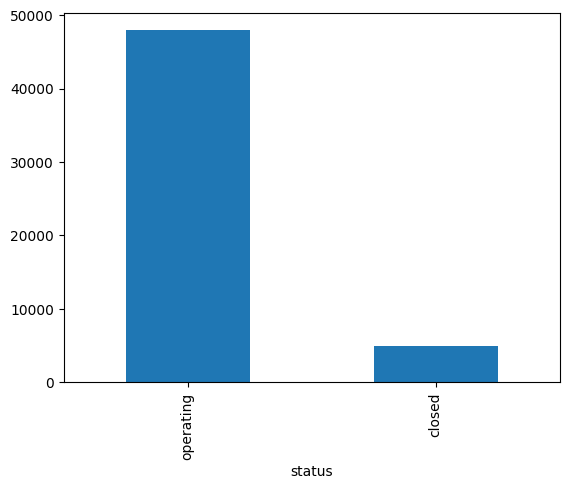

In [28]:
train_df.status.value_counts().plot(kind='bar')

In [29]:
def calc_lifetime(row):
    if row['status'] =='closed':
        return (row['closed_at'] - row['founded_at']).days
    else:
        return (pd.to_datetime('2018-01-01') - row['founded_at']).days

In [30]:
train_df['lifetime'] = train_df.apply(calc_lifetime, axis=1)
train_df = train_df[~(train_df.lifetime < 0)]


test_df['lifetime'] = test_df.apply(calc_lifetime, axis=1)
test_df = test_df[~(test_df.lifetime < 0)]


In [31]:
# create test/sample/ground truth kaggle datasets


ground_truth_df = test_df.copy()[['name', 'status']]
sample_submit_df = test_df.copy()[['name', 'status']]

ground_truth_df_public, ground_truth_df_private = train_test_split(ground_truth_df, test_size=0.5, 
                                                                   stratify=ground_truth_df['status'], 
                                                                   random_state=42)

ground_truth_df.loc[ground_truth_df_public.index,'Usage'] = 'Public'
ground_truth_df.loc[ground_truth_df_private.index,'Usage'] = 'Private'

ground_truth_df.to_csv('kaggle_startups_ground_truth_01.csv', index=False)
test_df.drop(columns=['status', 'lifetime']).to_csv('kaggle_startups_test_01.csv', index=False)
sample_submit_df['status'] = sample_submit_df['status'].apply(fill_status_random)
sample_submit_df.to_csv('kaggle_startups_sample_submit_01.csv', index=False)

In [32]:
test_df.shape, ground_truth_df.shape, sample_submit_df.shape

((13211, 14), (13211, 3), (13211, 2))

In [33]:
train_df.shape, test_df.shape

((52829, 14), (13211, 14))

In [34]:
train_df['lifetime_category'] = pd.cut(train_df.lifetime,bins=[0, 300, 1000, 100000 ], labels=['1-year', '3-year', '5-year'])
test_df['lifetime_category'] = pd.cut(test_df.lifetime,bins=[0, 300, 1000, 100000 ], labels=['1-year', '3-year', '5-year'])

In [35]:
train_X = train_df.drop(columns=['status', 'name', 'category_list'])
train_y = train_df.status

test_X = test_df.drop(columns=['status', 'name', 'category_list'])
test_y = test_df.status

In [36]:
num_cols = train_X.select_dtypes(include='number').columns.to_list()
cat_cols = train_X.select_dtypes(exclude=['number','datetime']).columns.to_list()


In [37]:
num_cols

['funding_total_usd', 'funding_rounds', 'lifetime']

In [38]:
cat_cols

['country_code', 'state_code', 'region', 'city', 'lifetime_category']

In [39]:
prepocessing = make_column_transformer((StandardScaler(), num_cols), 
                                       (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols), 
                                       remainder='drop')

In [40]:
prepocessing

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['funding_total_usd', 'funding_rounds',
                                  'lifetime']),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['country_code', 'state_code', 'region',
                                  'city', 'lifetime_category'])])

In [41]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(prepocessing, RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42, class_weight='balanced'))

In [42]:
pipeline.fit(train_X, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds',
                                                   'lifetime']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['country_code', 'state_code',
                                                   'region', 'city',
                                                   'lifetime_category'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        n_estimators=300, random_state=42))])

In [43]:
threshold = 0.4
predict_proba = pipeline.predict_proba(test_X)
predicted = (predict_proba[:,0] >= threshold).astype('int')

In [44]:
predict = np.where(predicted==1, 'closed', 'operating').tolist()

In [45]:
f1_score(test_y, predict, pos_label='closed')

0.7109546854377474

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

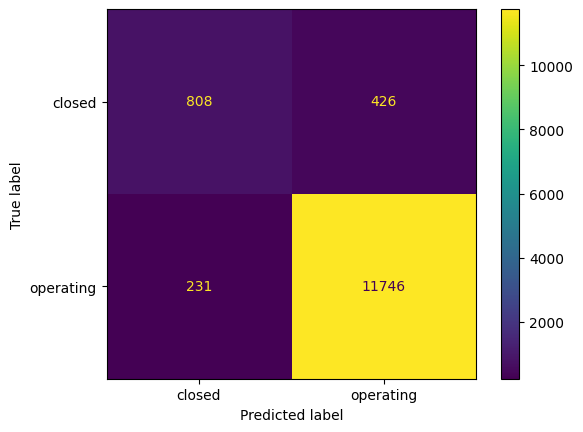

In [47]:
ConfusionMatrixDisplay.from_predictions(test_y, predict)

In [48]:
imp = pipeline.steps[-1][1].feature_importances_
name = pipeline.steps[-2][1].get_feature_names_out()

<Axes: >

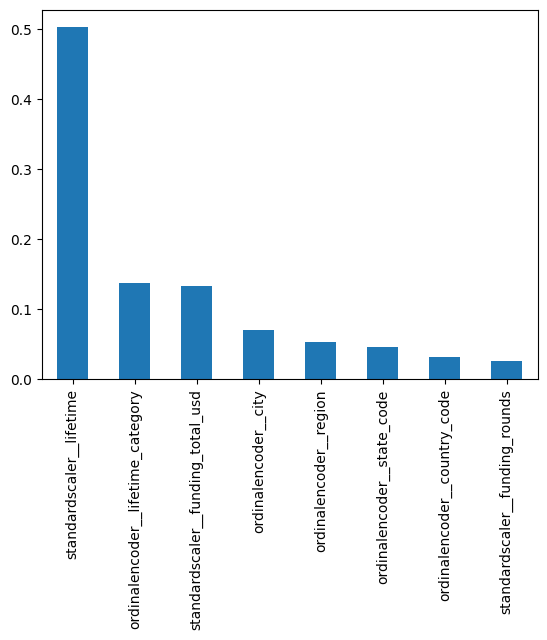

In [49]:
pd.Series(index=name, data=imp).sort_values(ascending=False).plot(kind='bar')

In [50]:
submit_predict = pd.DataFrame()
submit_predict['name'] = test_df['name']
submit_predict['status'] = predict
submit_predict.to_csv('kaggle_startups_sample_submit_predict_01.csv', index=False)

In [51]:
submit_predict

,name,status
14075,Crystalsol,operating
29476,JBI Fish & Wings,operating
12344,COINPLUS,operating
26995,Imagine Communications,operating
16031,DNA13,operating
...,...,...
30014,Jymob,operating
23244,GlobaTrek,operating
27704,Inkd.com,operating
1687,AdWill,operating


In [52]:
ground_truth_df.shape, test_df.shape, submit_predict.shape

((13211, 3), (13211, 15), (13211, 2))